In [ ]:
from typing import List
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
from scipy import stats

In [ ]:
# Display all columns for DataFrame printouts. 
pd.set_option('display.max_columns', None)

# Filter a specific FutureWarning related to SciPy versions in some environments.
warnings.filterwarnings('ignore', message="Unlike other reduction functions", category=FutureWarning)

## Predicting genre using audio characteristics

Let's see if we are able to predict the genres of songs in our dataset using the different audio features of tracks that were identified by Spotify, like "loudness" or "danceability."

We'll start by importing our .csv data into pandas. We can drop popularity, because hypothetically if we are seeing a song for the first time it is unlikely that we'll know the popularity rating.

In [ ]:
tracks = pd.read_csv('data/audio_features_5.3_clean.csv')
tracks = tracks.drop(['popularity'], axis=1)

seed = 538

To make our prediction task more managable, we'll focus on predicting the genres that most frequently occur in our dataset. In early modeling, we found that with the full dataset of 132 genres basic ML models have trouble distinguishing the classes.

In [ ]:
N_TOP_GENRES = 10

selected_genres = list(tracks.groupby(by='genre') \
                       .size() \
                       .sort_values(ascending=False) \
                       .head(N_TOP_GENRES) \
                       .index)

tracks = tracks[tracks.genre.isin(selected_genres)]

## Initial visualization

We'll perform some initial visualizations to get a better sense of our data.

So that we can see the coorelation between our features and genre, we'll encode genre with label encoder.

In [ ]:
# Encode genre with label encoder.
label_enc = LabelEncoder()
tracks_enc = tracks.copy(deep=True)

# Label encode the genre column.
tracks_enc[tracks_enc.columns[15]] = label_enc.fit_transform(tracks_enc.genre)

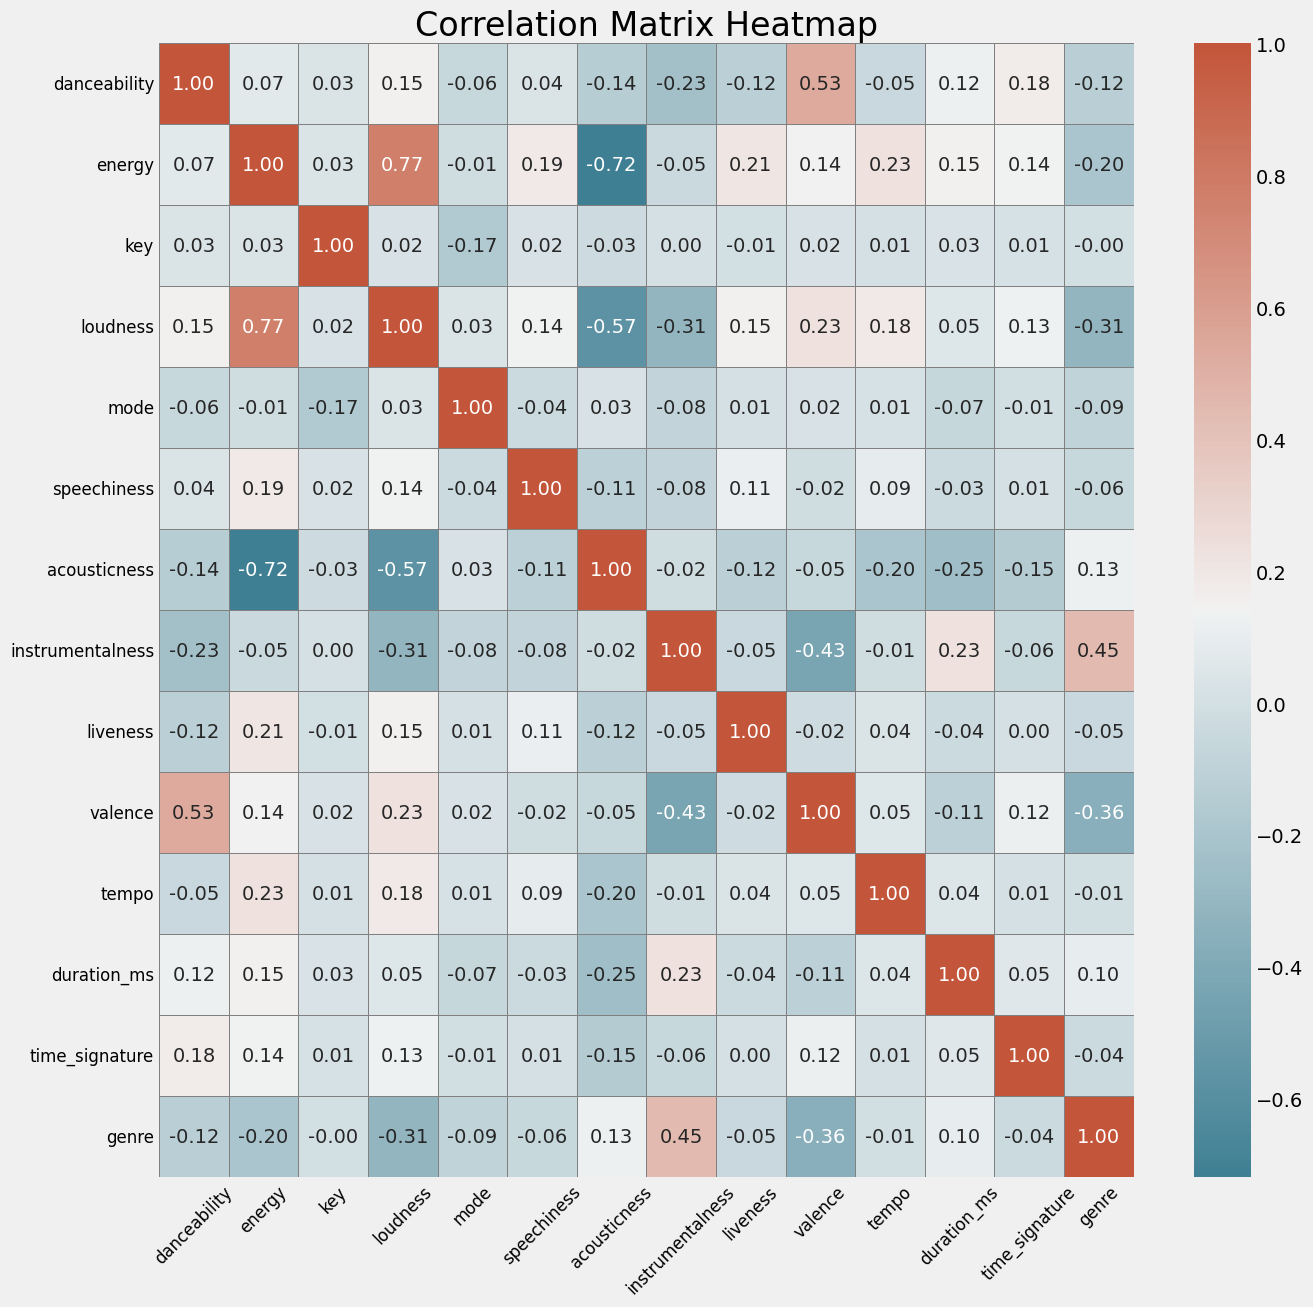

In [ ]:
# Change plot style to fivethirtyeight.com's style.
plt.style.use('fivethirtyeight')

# Coorelation matrix heatmap.
fig = plt.figure(figsize=(14, 14))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tracks_enc.corr(), 
            annot=True,
            # Specify the annotation format to be two decimal places 
            fmt='.2f', 
            cmap=cmap, 
            linewidths=0.5, 
            linecolor='gray')
plt.title("Correlation Matrix Heatmap", fontsize=24)
# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show();

Overall, there is high colinearity between some features, and a reasonably strong relationship between some of our features and genre.

Because our features are not independent given the class label, we will likely not get good performance withi certain classifiers like Naive Bayes that rely on independence.

Let's also check the distribution of our features.

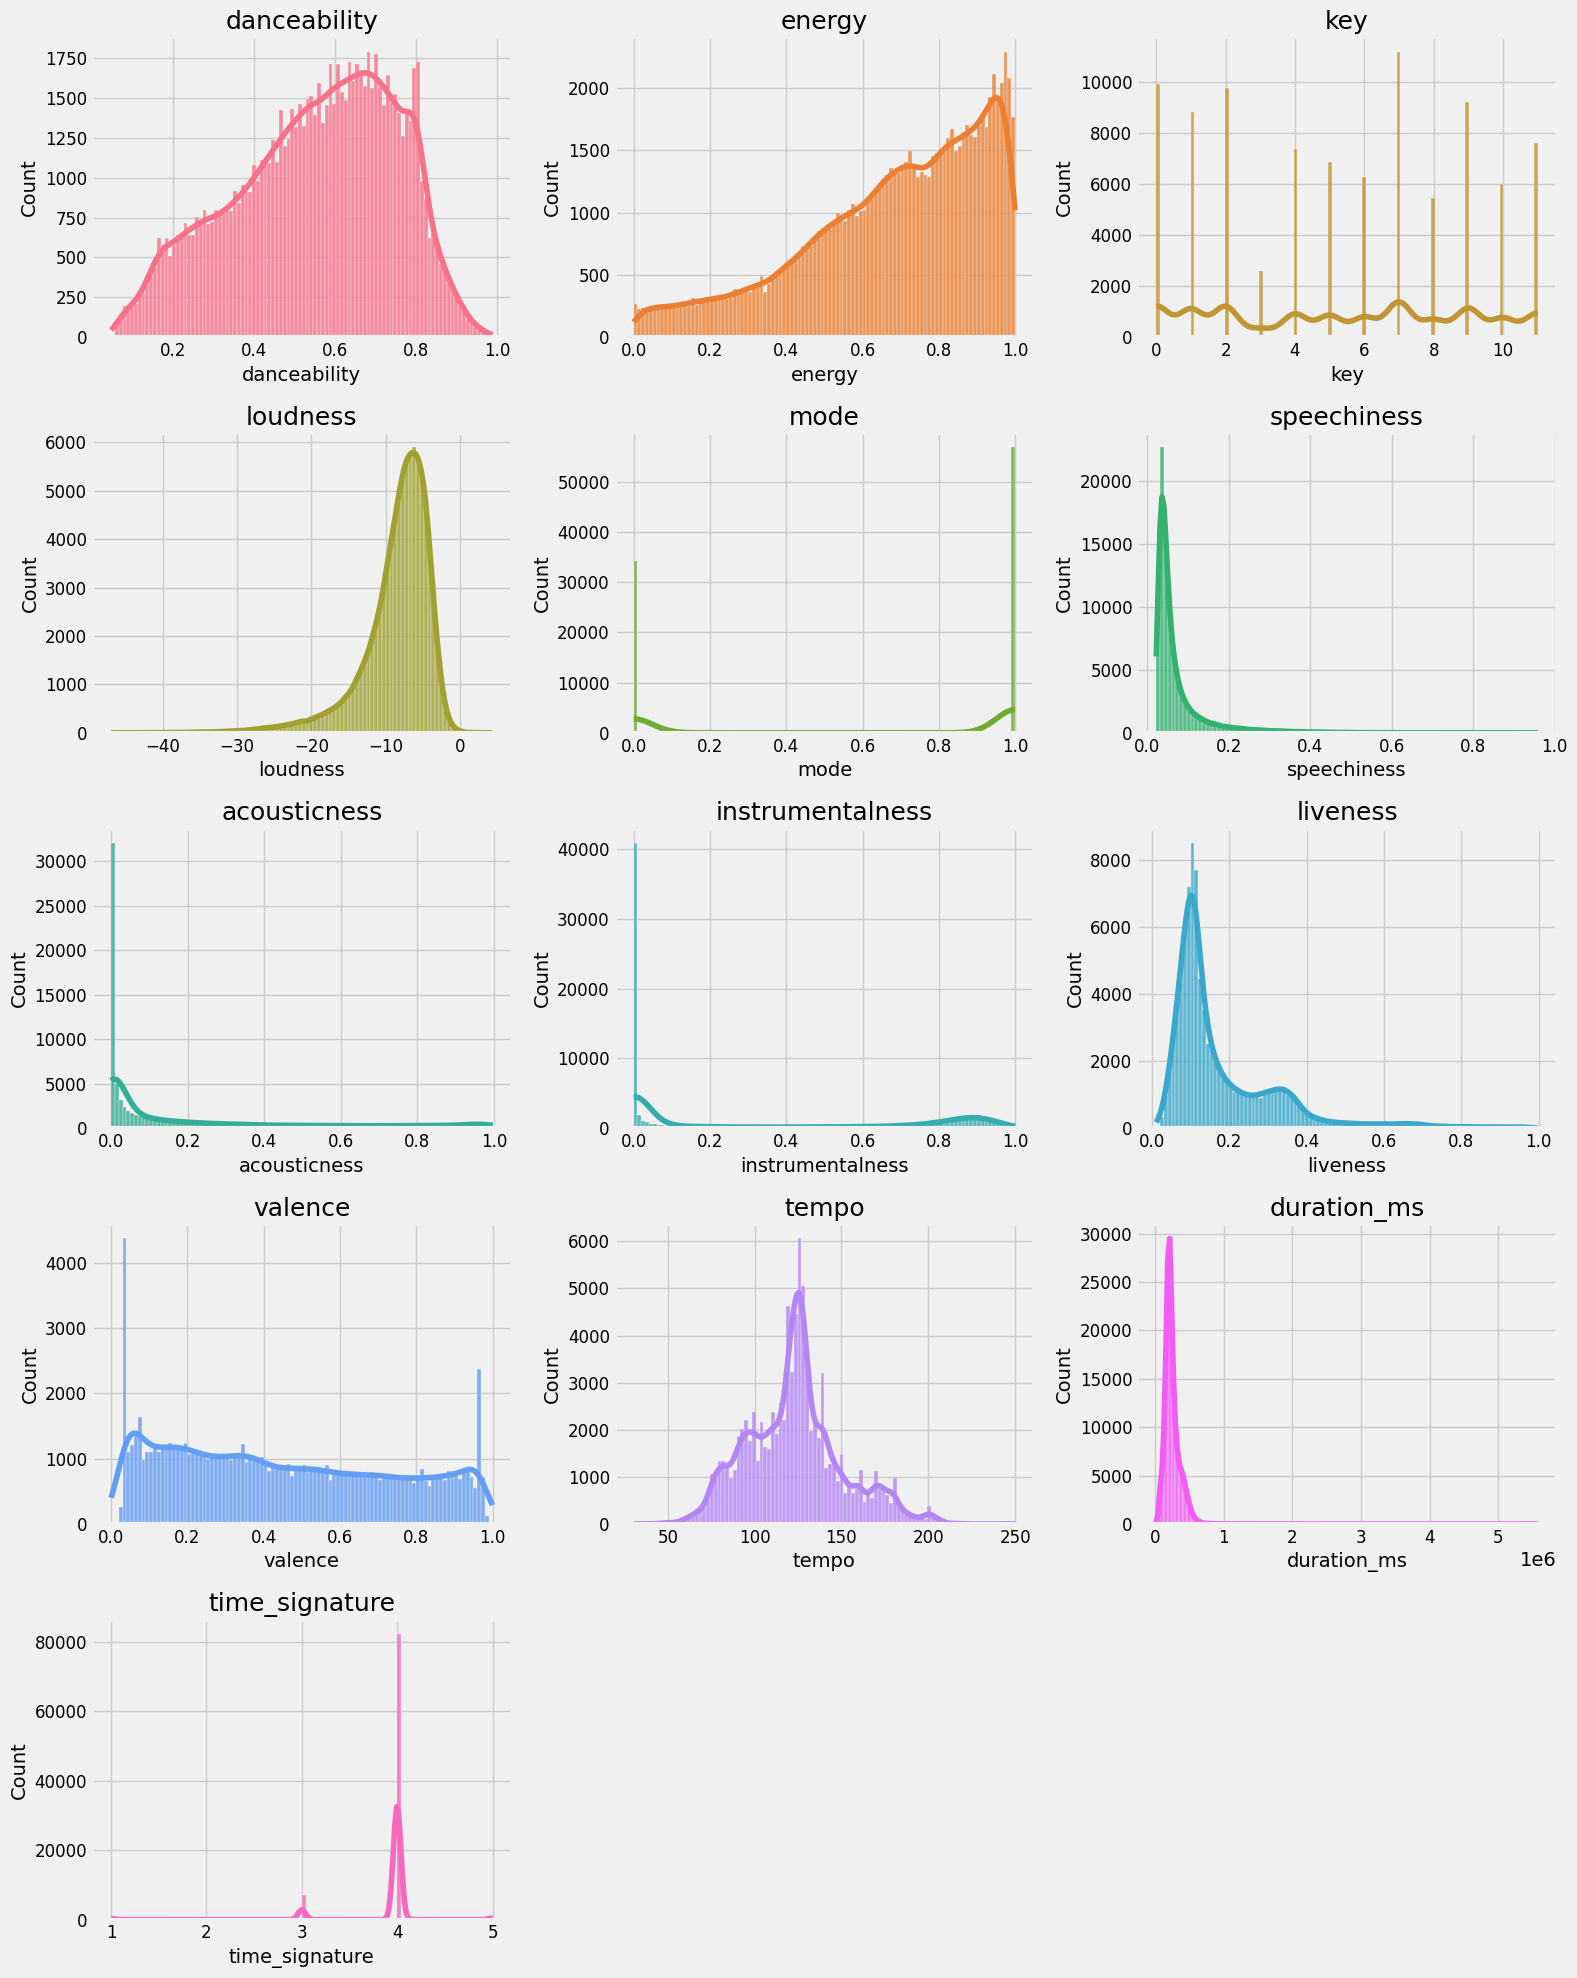

In [ ]:
# Select columns with numerical data types
cols = tracks.select_dtypes(include={'int64', 'float64'}).columns
ncols = 3

# Calculate the number of rows needed based on the number of columns
nrows = (len(cols) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(16, 4 * nrows), 
                         # Give subplots an independent y-axis.
                         sharey=False)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Set the color palette for the histograms
colors = sns.color_palette('husl', len(cols))

for i, col in enumerate(cols):
    sns.histplot(tracks, 
                 x=col, 
                 # Set the number of bins for the histogram
                 bins=100, 
                 ax=axes[i], 
                 color=colors[i], 
                 # Show a kernel density estimate plot on top of the histogram
                 kde=True, 
                 # Adjust transparency
                 alpha=0.8)
    axes[i].set_title(col, fontsize=18)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=12)

# Remove any extra subplots if the number of columns is not a multiple 
# of the number of rows
for i in range(len(cols), nrows * ncols):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

Based on these plots, we can see that energy, loudness, and liveness are moderately skewed. Speechiness, acousticness, and instrumentalness are even more skewed. Valence is roughly uniformly distributed, with some clustering at both extremes.

Because some of our features are skewed and not normally-distributed, we'll have to use techniques that are robust to these distributions. Furthermore, we should keep in mind that, as we established in the previous data cleaning notebook, some of our features have significant numbers of outliers.

Let's also look at class imbalance, which is another important consideration when modeling.

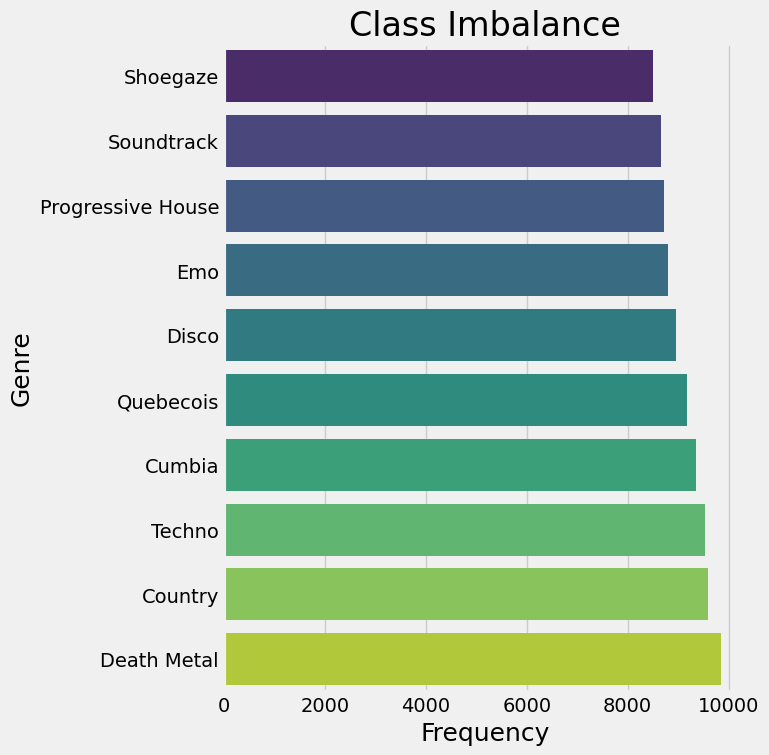

In [ ]:
# Count the number of tracks in each genre
class_counts = tracks['genre'].value_counts() \
                            .sort_values(ascending=True)

plt.figure(figsize=(6, 8))

# Set the color palette for the bar plot
color_palette = sns.color_palette("viridis", 
                                  n_colors=len(class_counts))

sns.barplot(x=class_counts.values,
            y=class_counts.index,
            # Plot the bars horizontally
            orient='h',
            palette=color_palette)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Genre', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Class Imbalance', fontsize=24)
plt.show()

Overall, there is good balance between our classes, which will make our classification task easier.

### References:
* https://seaborn.pydata.org/generated/seaborn.histplot.html
* https://napsterinblue.github.io/notes/python/viz/subplots/
* https://seaborn.pydata.org/generated/seaborn.heatmap.html
* https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
* https://stackoverflow.com/questions/37902459/seaborn-color-palette-as-matplotlib-colormap
* https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

## Feature engineering

We'll start by encoding genre so that we can use it in our classification models.

In [ ]:
genre_encoder = LabelEncoder()
tracks[tracks.columns[15]] = genre_encoder.fit_transform(tracks.genre)

Our data contains textual features which may make it easier to separate out different genres. In particular, we have song name and artist name for each track. Because artist name is more likely to be a short (and unique), we'll focus on song name.

We'll need to transform this data so that our different classification models can utalize it.

First, we'll create a new column in our DataFrame with the lowercase data and with non-words and non-spaces removed.

In [ ]:
tracks['cleaned_song_name'] = tracks['song_name'].str \
                                                .lower() \
                                                .str \
                                                .replace('[^\w\s]', '')

<command-3216776015709896>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .replace('[^\w\s]', '')


To avoid data leakage, we need to perform a train test split at this point before performing feature selection with the text features.

In [ ]:
# Drop the target, the track id, and the text columns we're not using.
X = tracks.drop(['genre',
                 'song_name',
                 'artist_name',
                 'spotify_track_id'], axis=1)

# Set y equal to the target.
y = tracks.genre

# 80-20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=seed)

Next, we'll create a matrix of TF-IDF values, which combines the frequency of a word in a given document compared to its uniqueness across all the given song names.

We'll leave in stopwords for now. It seems possible that some genres may have systematically more of some kinds of stopwords (for example, if the genre has longer or more complex titles). Also, we have a few genres in our dataset from predominantly non-Anglophone regions, so stopwords may help our model distinguish between genres with different primary languages.

In [ ]:
# nltk.download('stopwords')
# combined_stopwords_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish')

# Create a TfidfVectorizer object with English stop words
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the training data and transform the text data into 
# a matrix of features
X_text_train = vectorizer.fit_transform(X_train['cleaned_song_name']);

Because we can't train our model using every unique word (for computational reasons), we'll find a few top words in each genre and use those as new features. 

To separate out our features, we'll use Multinomial Naive Bayes, which is efficient for large datasets and will allow us to find the words that create the most separation between our genres.

We'll train the MNB classifier as a baseline, and then use .feature_log_prob_ to get the probability that a feature is present given that a certain genre.

In [ ]:
# Train a Multinomial Naive Bayes classifier on the TF-IDF features 
# and the training labels
mnb = MultinomialNB().fit(X_text_train, y_train)

# Number of top features to keep for each genre
N_FEATURES = 10

# Extract genres and words in the vectorizer
genres = genre_encoder.classes_
feature_names = np.array(vectorizer.get_feature_names_out())


# Make empty list and dict to store the top features
top_features_list = []
top_features_by_genre = {}


# For each genre, find the top N_FEATURES features with the highest log 
# probabilities according to MNB.
for i, genre in enumerate(genres):
    top_n = np.argsort(mnb.feature_log_prob_[i])[-N_FEATURES:]
    top_features_list.extend(feature_names[top_n])
    top_features_by_genre[genre] = feature_names[top_n]

Using that code, we were able to get a list of the most important words in our dataset, both sorted by genre and all together in a list.

We'll use the top_features_by_genre for visualization purposes, and top_features_list for our new features.

Let's look at the words identified by our MNB model as being the most important. We will also get the proportions of each word in each genre so we can see how likely it is that our models will encounter a given word.

In [ ]:
def calculate_word_proportions(df, word_dict, genre_encoder):
    # Make a deep copy of the DataFrame to avoid modifying the original
    df = df.copy(deep=True)

    # Convert the genre labels from encoded to text form
    df.genre = genre_encoder.inverse_transform(df.genre)

    proportions = {}

    # For each genre, calculate the proportion of each top word 
    for genre, words in word_dict.items():
        # Subset the DataFrame to include only the rows with the current genre label
        genre_df = df[df['genre'] == genre]
        genre_word_proportions = {}

        # For each top word, calculate the proportion of song names that contain the word
        for word in words:
            # Check if song name contains word with lambda function.
            count = genre_df['song_name'].apply(lambda x: word.lower() in x.lower()).sum()

            # Calculate proportion
            genre_word_proportions[word] = count / len(genre_df)

        # Store the results in the dict.    
        proportions[genre] = genre_word_proportions
    return proportions

# Calculate the proportions
word_proportions = calculate_word_proportions(tracks, 
                                              top_features_by_genre, 
                                              genre_encoder)

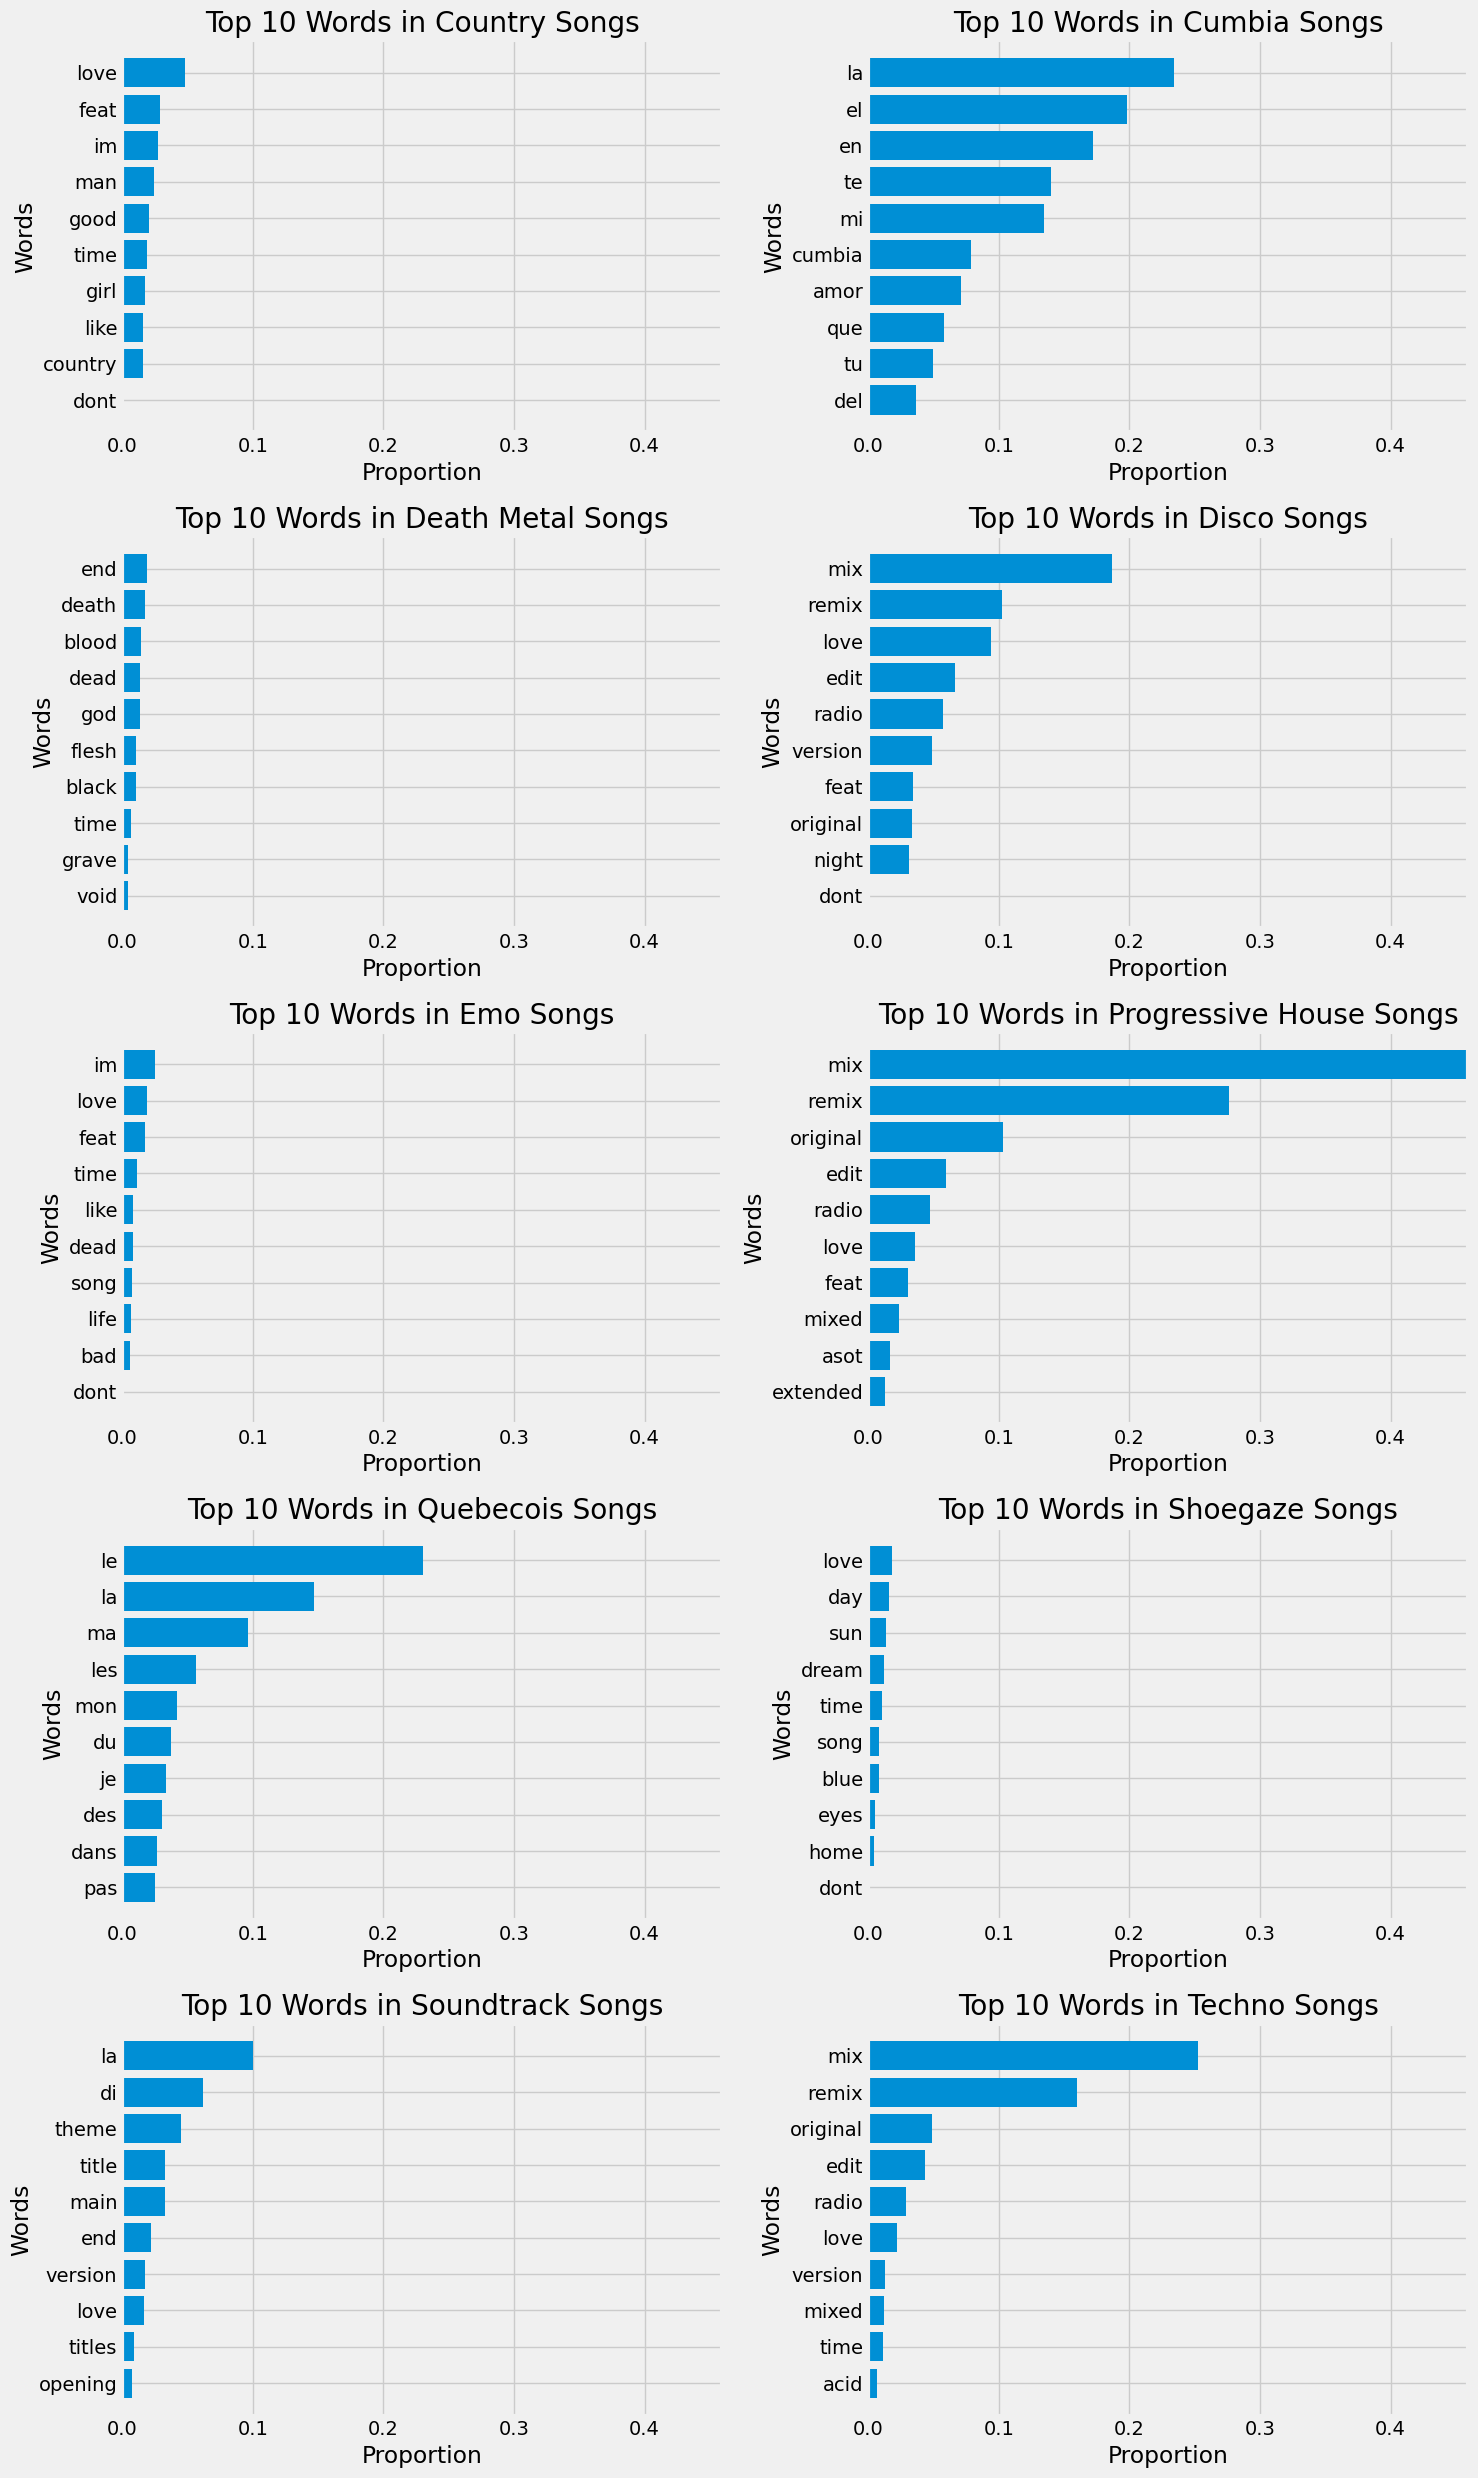

In [ ]:
def plot_top_words_all_genres(word_proportions, genres, top_n, ncols=2):
    # Calculate the number of rows and columns for the subplot grid
    nrows = (len(genres) + ncols - 1) // ncols

    # Find the maximum proportion value across all genres
    max_proportion = max(max(proportions.values()) for proportions in word_proportions.values())

    # Create a figure with a subplot grid of size nrows x ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

    for i, genre in enumerate(genres):
        genre_proportions = word_proportions[genre]

        # Sort proportions by value.
        sorted_items = sorted(genre_proportions.items(), 
                              key=lambda x: x[1], 
                              reverse=True)
        
        # Take the top n values in the sorted list.
        top_words = sorted_items[:top_n]
        words, proportions = zip(*top_words)

        # Get the subplot axes for the current genre
        ax = axes[i // ncols][i % ncols]

        # Plot the top words for the current genre as a horizontal bar chart
        ax.barh(words, proportions)

        # Set the x-axis limit to the maximum proportion value across all genres
        ax.set_xlim(0, max_proportion)
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Words')
        ax.set_title(f'Top {top_n} Words in {genre} Songs')

        # Invert the y-axis to display the top words at the top of the chart
        ax.invert_yaxis()

    # If number of genres is not a multiple of ncols, remove the extra subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols][j % ncols])

    plt.tight_layout()
    plt.show()


plot_top_words_all_genres(word_proportions, genre_encoder.classes_, top_n=10)


Unfortunately, there aren't too many words that stand out. There may still be some interesting trends, however. Techno and Disco both have lots of song titles with the word 'mix,' for example. Also, Cumbia and Quebecois have a different set of stopwords in Spanish and French respectively.

Now we'll use concat to add those words as indicator variables to our train and test DataFrames, so we can use them as features.

In [ ]:
# Define a function to create a DataFrame with indicator columns for the words
def create_top_words_df(tracks, words):
    new_columns = []

    # Loop over each word and create a new indicator column for the word
    for word in words:
      # Use a lambda function with an if statement to create indicator columns
      new_column = tracks['cleaned_song_name'].apply(lambda x: 1 if word in x.split() else 0)
      new_columns.append(new_column.rename(word))

    # Concatenate the new indicator columns into a single DataFrame and return.
    return pd.concat(new_columns, axis=1)

# Call the create_top_words_df() function to create indicator columns for the 
# top words in the training and testing data
top_words_train = create_top_words_df(X_train, top_features_list)
top_words_test = create_top_words_df(X_test, top_features_list)

# Drop the 'cleaned_song_name' column from the training and testing data
X_train = X_train.drop(['cleaned_song_name'], axis=1)
X_test = X_test.drop(['cleaned_song_name'], axis=1)

# Concatenate the indicator columns with the train and test DataFrames.
X_train = pd.concat([X_train, top_words_train], axis=1)
X_test = pd.concat([X_test, top_words_test], axis=1)

Now, we will use SMOTE over-sampling to randomly generate new datapoints for the remaining under-represented classes, with the new random points being based on the existing data in those classes.

In [ ]:
over_sampler = SMOTE()
X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)

### References:
* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
* https://www.geeksforgeeks.org/matplotlib-figure-figure-delaxes-in-python/
* https://www.geeksforgeeks.org/how-to-use-if-else-elif-in-python-lambda-functions/
* https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

## K-Nearest Neighbors

Let's start with K-Nearest Neighbors (KNN) as a baseline to see what kind of accuracy we can achieve.

KNN works by looking at our new points and using their proximity to our trainset points to predict the class.

The distance can be calculated in various ways in n-dimensional space (where n is the number of predictors in our dataset).

KNN seems like a good fit for our purposes, as it doesn't make assumption about the underlying distribution of the data, which is good given that our data are not normally distributed.

We'll have to pick our parameters carefully when tuning, however, because KNN can be computationally intensive with large datasets, and tends to be highly sensitive to the k parameter.

It's important to note that we found a high number of outliers in our previous data cleaning analysis, which seem simply to be extreme values rather than bad data. Some of the features are also highly skewed.

Because KNN is sensitive to the scale of features and to outliers, we'll employ StandardScaler to preprocess our data. (In previous, smaller-scale testing, StandardScaler always outperformed RobustScaler and MinMaxScaler for this model type.)

StandardScaler works by transforming each feature in the dataset to have a mean of 0 and a standard deviation of 1, effectively standardizing the features and ensuring they are on the same scale. This helps mitigate the influence of outliers and the impact of skewed distributions on our model. By transforming the data with StandardScaler, you are addressing the scale sensitivity issue of KNN and potentially improving the accuracy of the model.

Because we want to try out multiple parameters, we'll use GridSearchCV. This method exhaustively tries the chosen parameters and compares the results using cross-validation. In this case, we'll use K-fold validation with 5 folds, which will allow us to compare our hyperparameters using the trainset while reducing overfitting that might prevent our choices from generalizing.

In previous testing on a subset of our data, we tried Euclidean, Minkowski, and Manhattan distance. All three performed similarly, and while Manhattan performed slightly better, it had a significantly higher computational time, making it difficult to test other parameters. For that reason, we are training our KNN model using Euclidean distance.

In [ ]:
start = time.time()

# Create a pipeline with a scaler and a KNN classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(metric='euclidean'))
    ])

# Define the parameter grid for tuning
param_grid = {
    'knn__n_neighbors': list(range(3, 34, 6))
    }

# Use GridSearchCV to find the best combination of parameters
knn_grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", knn_grid.best_params_)
print("Best score found: ", knn_grid.best_score_)

test_score = knn_grid.score(X_test, y_test)
print("Test set score: ", test_score)

stop = time.time()
print('Time to run:', round(stop - start, 2))

Best parameters found:  {'knn__n_neighbors': 15}
Best score found:  0.5917648549347523
Test set score:  0.5964998902786921
Time to run: 689.99


In [ ]:
knn_results = pd.DataFrame(knn_grid.cv_results_)

# Export for future analysis.
knn_results.to_csv('knn_results.csv', index=False, encoding='utf-8')

# Display top performing combinations.
knn_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.323910,0.020217,11.988051,0.120075,15,{'knn__n_neighbors': 15},0.585582,0.591347,0.588179,0.592107,0.601609,0.591765,0.005446,1
3,0.297444,0.007753,12.052571,0.108071,21,{'knn__n_neighbors': 21},0.585202,0.593247,0.587989,0.590650,0.600976,0.591613,0.005394,2
4,0.285374,0.003518,12.121914,0.164793,27,{'knn__n_neighbors': 27},0.583302,0.590903,0.587926,0.590016,0.599138,0.590257,0.005161,3
1,0.379607,0.009423,11.898568,0.069057,9,{'knn__n_neighbors': 9},0.582161,0.587926,0.585329,0.585455,0.600215,0.588217,0.006272,4
5,0.287605,0.003156,12.177716,0.052759,33,{'knn__n_neighbors': 33},0.581781,0.586532,0.585392,0.589446,0.597808,0.588192,0.005399,5


Overall, our top k values took a similar time to score, and achieved a similar CV score. To see the overall shape of our results, let's plot the different values of k against the CV scores.

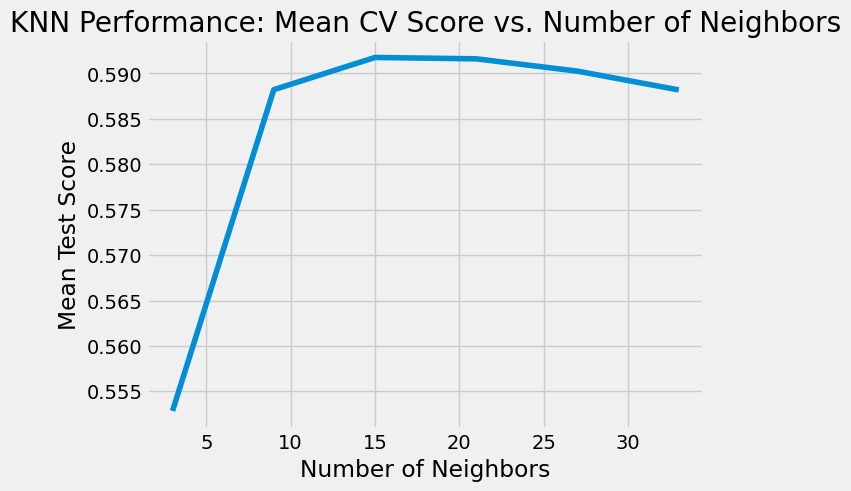

In [ ]:
ax = sns.lineplot(data=knn_results, x='param_knn__n_neighbors', 
                  y='mean_test_score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.title('KNN Performance: Mean CV Score vs. Number of Neighbors')
plt.show()

We can see that performance increases sharply as we go up to 15 neighbors, and then slowly starts to decline from there on out. This gives us an optimal k value to use. Overall, we should be somewhat happy with this result. Lower k values make us less prone to overfitting, and so a k value of 15 is a better result than a much higher k value.

Now that we have tried out a variety of different hyperparameters, we will train a final version of our model.

In [ ]:
# Train new KNN model with best parameters
final_knn_pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsClassifier(metric='euclidean',
                                                        n_neighbors=15))
                    ])

final_knn_pipe.fit(X_train_smote, y_train_smote)

knn_pred = final_knn_pipe.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
knn_pred_real_names = genre_encoder.inverse_transform(knn_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, knn_pred_real_names)
for line in report_str.split('\n'):
    print(line)

                   precision    recall  f1-score   support

          Country       0.44      0.64      0.52      1854
           Cumbia       0.75      0.79      0.77      1928
      Death Metal       0.73      0.80      0.76      1958
            Disco       0.55      0.54      0.54      1742
              Emo       0.48      0.46      0.47      1750
Progressive House       0.55      0.61      0.58      1767
        Quebecois       0.59      0.49      0.53      1849
         Shoegaze       0.58      0.49      0.53      1768
       Soundtrack       0.73      0.71      0.72      1738
           Techno       0.62      0.42      0.50      1874

         accuracy                           0.60     18228
        macro avg       0.60      0.59      0.59     18228
     weighted avg       0.60      0.60      0.59     18228



Using this method, we achieved an accuracy of 60%, which means that our model performs significantly better than chance (with 10 genres, chance would be 10% accuracy). We can see that model has more trouble classifying some genres compared to others. Cumbia, Death Metal, and Soundtrack music were much easier to categorize, with f1-scores close to .7. Country, Techno, and Emo were harder, by contrast, with scores closer to .5.

Country stands out for having high recall, whereas Techno stands out for higher precision. This means that for tracks that we predict to be Techno there are fewer false positives, but we didn't identify as many Techno songs in the dataset. In contrast, we have more false positives for Country, but there are fewer Country songs we weren't able to identify.

Before we move onto trying other models, let's plot a confusion matrix to see if there were any patterns in which genres were confused for which other genres.

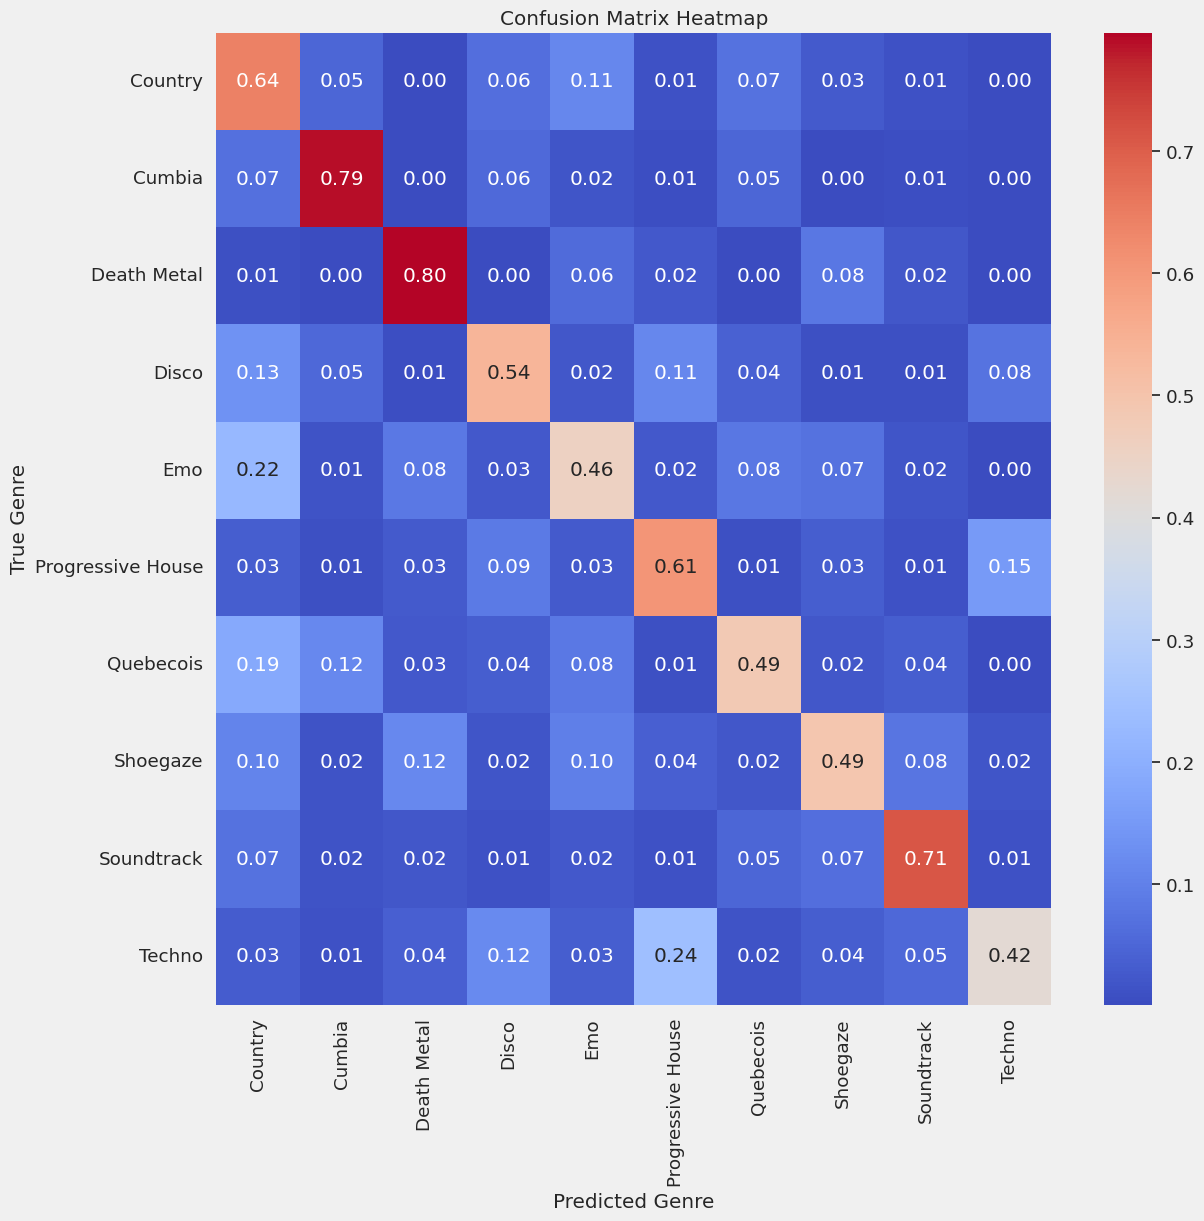

In [ ]:
cm = confusion_matrix(y_test_real_names, knn_pred_real_names)

# Normalize the confusion matrix values to be a proportion by dividing each 
# element by the sum of the elements in the same row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

A few things stand out. There was significant interference between Progressive House and Techno in our results, which makes sense given that these are related EDM genres. 12% of Techno songs were also misclassified as Disco. If this result shows up in our other models, it suggest that one way to improve accuracy in the future would be to find additional features that can separate out these most frequently confused genres.

### References:
* https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
* https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html
* https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
* https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
* https://stackoverflow.com/questions/44947574/what-is-the-meaning-of-mean-test-score-in-cv-result
* https://campus.datacamp.com/courses/hyperparameter-tuning-in-python/grid-search?ex=8
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://stackoverflow.com/questions/52870022/inverse-transform-method-labelencoder
* https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
* https://seaborn.pydata.org/generated/seaborn.heatmap.html

## Logistic Regression

Let's proceed with Logistic Regression as our next model to see if we can improve upon the accuracy achieved by K-Nearest Neighbors.

Logistic Regression is a simple linear model that estimates the probability of an outcome by fitting a logistic function to the data. It is most suitable for binary classification problems, but we can use it for multi-class classification using one-vs-all classification, where the model predicts separate probabilities for each class as a binary problem.

Our previous data cleaning analysis revealed a high number of outliers and skewed features. To handle these issues, we'll apply StandardScaler to preprocess the data, just as we did with KNN. This will standardize the features, ensuring they are on the same scale and mitigating the influence of outliers and skewed distributions on our model.

When working with Logistic Regression, it is essential to perform regularization to prevent overfitting and improve generalization. We'll use GridSearchCV to search for the best regularization parameter 'C' and the type of regularization to use (L1, like Lasso, or L2, like Ridge). We will use K-fold cross-validation with 5 folds, which helps in comparing the hyperparameters using the trainset and reduces the chances of overfitting.

We'll pick the liblinear solver, which works with both l1 and l2 regularization, and is suitable for multi-class classification. We'll also pick a maxiter hyperparameter of 5000, as in early subset testing this was roughly the value required to get the model to converge.

Choosing the right range of 'C' values for regularization is crucial for finding the best Logistic Regression model. The 'C' parameter controls the inverse of the regularization strength, meaning smaller 'C' values correspond to stronger regularization and larger 'C' values correspond to weaker regularization.

We'll look at a logarithmic range between 10^-4 and 10^2 to see which C value performs the best in cross validation.

In [ ]:
start = time.time()

lr_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('logistic_regression', LogisticRegression(solver='liblinear',
                                                multi_class='auto', 
                                                max_iter=5000, 
                                                random_state=seed))
    ])

# Define the parameter grid for tuning
param_grid = {
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__C': np.logspace(-4, 2, 15)
}

# Use GridSearchCV to find the best combination of parameters
lr_grid = GridSearchCV(lr_pipe, param_grid, cv=5, scoring='accuracy')
lr_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", lr_grid.best_params_)
print("Best score found: ", lr_grid.best_score_)

test_score = lr_grid.score(X_test, y_test)
print("Test set score: ", test_score)

stop = time.time()
print('Time to run:', round(stop - start, 2))

Best parameters found:  {'logistic_regression__C': 1.9306977288832496, 'logistic_regression__penalty': 'l2'}
Best score found:  0.5896363866717345
Test set score:  0.59715821812596
Time to run: 869.24


Overall, we were able to achieve a similar accuracy with this approach compared to KNN.

In [ ]:
lr_results = pd.DataFrame(lr_grid.cv_results_)

# Export for analysis later.
lr_results.to_csv('lr_results.csv', index=False, encoding='utf-8')

# Display top performing combinations.
lr_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__C,param_logistic_regression__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,8.809733,0.474072,0.027264,0.000754,1.930698,l2,"{'logistic_regression__C': 1.9306977288832496,...",0.588179,0.596225,0.590650,0.591283,0.581845,0.589636,0.004690,1
19,7.962602,0.520796,0.028540,0.002524,0.719686,l2,"{'logistic_regression__C': 0.7196856730011514,...",0.587799,0.596351,0.590397,0.591600,0.581971,0.589624,0.004725,2
23,10.243961,0.150601,0.027001,0.000582,5.179475,l2,"{'logistic_regression__C': 5.1794746792312125,...",0.587989,0.596288,0.590523,0.591093,0.581781,0.589535,0.004723,3
17,6.737258,0.716172,0.028032,0.002779,0.26827,l2,"{'logistic_regression__C': 0.2682695795279725,...",0.586976,0.596351,0.590397,0.591410,0.582415,0.589510,0.004647,4
22,7.852401,0.821502,0.027746,0.000830,5.179475,l1,"{'logistic_regression__C': 5.1794746792312125,...",0.587799,0.596351,0.590397,0.591093,0.581781,0.589484,0.004749,5


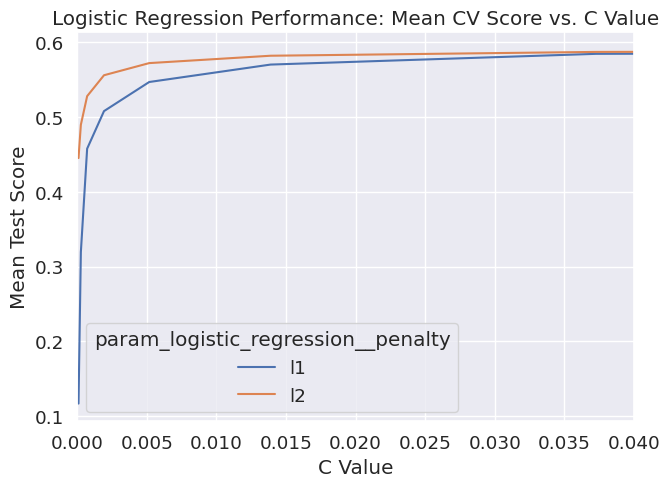

In [ ]:
ax = sns.lineplot(data=lr_results, 
                  x='param_logistic_regression__C', 
                  y='mean_test_score', 
                  # Create two lines based on penalty type.
                  hue='param_logistic_regression__penalty')
plt.xlabel('C Value')
plt.ylabel('Mean Test Score')
plt.xlim(0, .2)
plt.title('Logistic Regression Performance: Mean CV Score vs. C Value')
plt.show()

Interestingly, while the improvement curve flattens out rapidly around a C value of .02, the optimal points found by grid search are actually further along the curve, indicating that the decrease in performance for increasing values of C may reverse itself at higher values. 

Overall, an l1 regularization penalty performed better, although there was also a combination with l2 in our top five best performing combinations.

Future attempts to apply logistic regression to this dataset might consider a more fine-grained tuning that tries to look for other values of C. However, for this analysis, considering that the improvements from the higher values of C were modest, and considering that KNN is already performing better, we will leave the tuning process here for now.

We'll use the best hyperparameters that we identified to train a final logistic regression model.

In [ ]:
# Train new LR model with best parameters
final_lr_pipe = Pipeline([('scaler', RobustScaler()),
                        ('logistic_regression', LogisticRegression(solver='liblinear',
                                                                    multi_class='auto', 
                                                                    max_iter=5000, 
                                                                    C=1.9306977288832496,
                                                                    penalty='l2',
                                                                    random_state=seed))])

final_lr_pipe.fit(X_train_smote, y_train_smote)

lr_pred = final_lr_pipe.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
lr_pred_real_names = genre_encoder.inverse_transform(lr_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, lr_pred_real_names)
for line in report_str.split('\n'):
    print(line)

                   precision    recall  f1-score   support

          Country       0.47      0.58      0.52      1854
           Cumbia       0.72      0.75      0.73      1928
      Death Metal       0.75      0.82      0.78      1958
            Disco       0.54      0.53      0.54      1742
              Emo       0.45      0.55      0.49      1750
Progressive House       0.57      0.50      0.53      1767
        Quebecois       0.65      0.42      0.51      1849
         Shoegaze       0.59      0.58      0.58      1768
       Soundtrack       0.71      0.74      0.72      1738
           Techno       0.56      0.48      0.52      1874

         accuracy                           0.60     18228
        macro avg       0.60      0.60      0.59     18228
     weighted avg       0.60      0.60      0.60     18228



The most balanced class in KNN, Emo, is now more unbalanced for logistic regression. Other classes like country which were previously more unbalanced are now more balanced. This suggests that the imbalance between precision and recall that we identified earlier may be sensitive to our model choice and not something that emerges clearly from the underlying data.

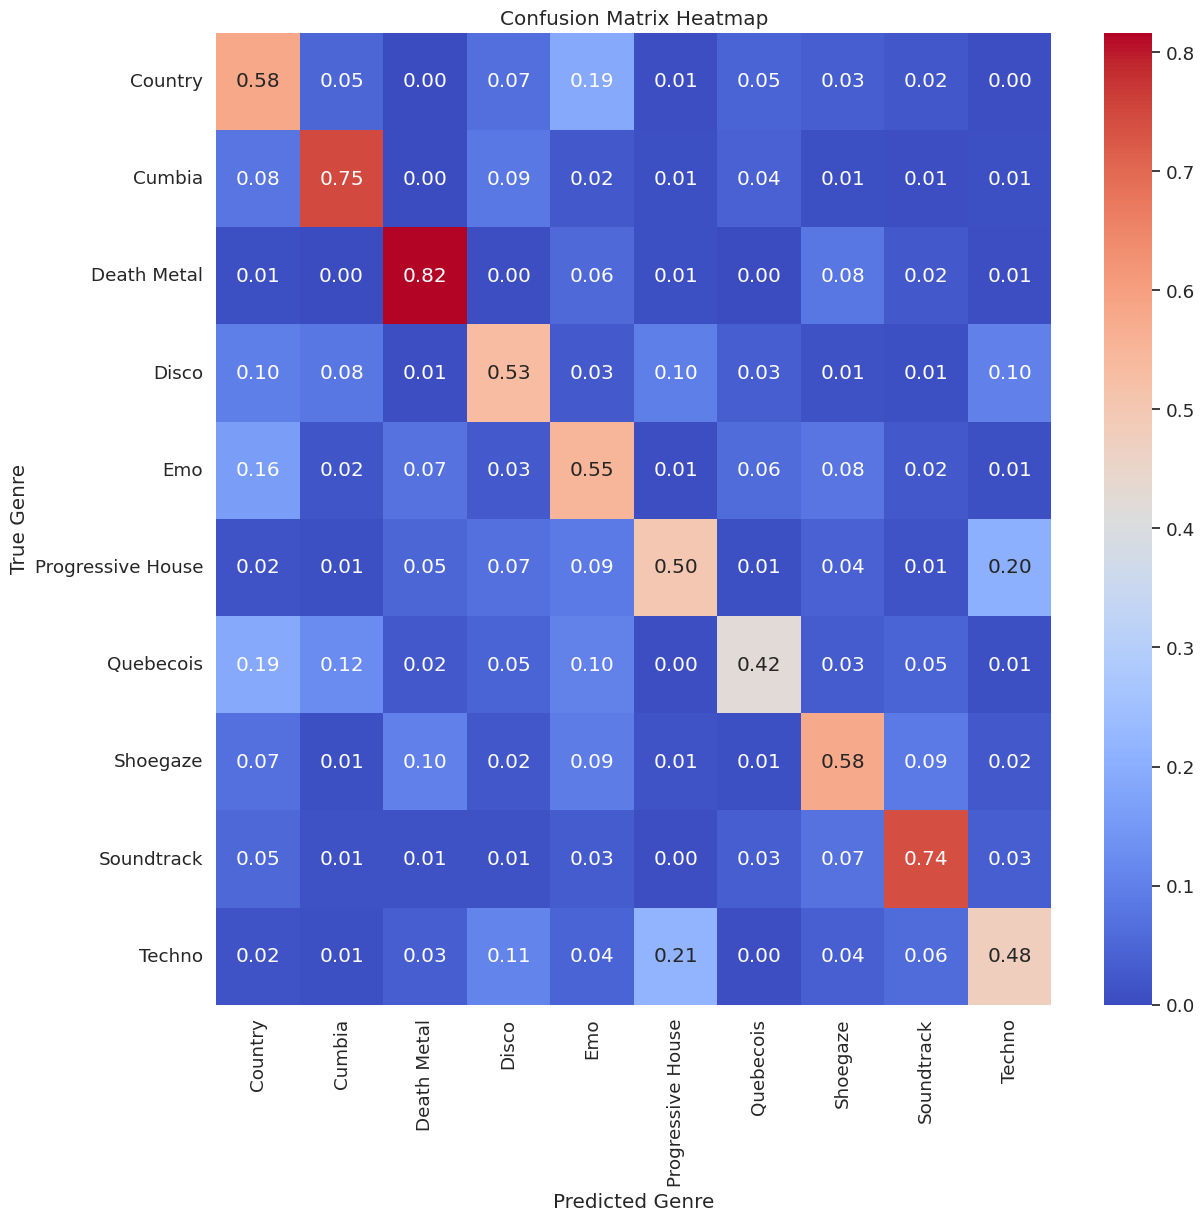

In [ ]:
cm = confusion_matrix(y_test_real_names, lr_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

While the imbalances between precision and recall for different classes shifted between KNN and logistic regression, the confusion between Progressive House, Techno, and, to a lesser extent, Disco, persisted. This suggests that this issue is less sensitive to our choice of model.

### References: 
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
* https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression
* https://stackoverflow.com/questions/58657544/l1-ratio-and-c-in-sklearn-linear-model-logisticregression
* https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization#:~:text=The%20differences%20between%20L1%20and,regularization%20solution%20is%20non%2Dsparse.

## Random Forest Classifier

Next, let's try a decision tree-based model, which works by repeatedly finding the feature that most reduces class impurity, progressively creating smaller groups until a stopping point is reached. This approach is combined with bagging, which takes a subset of the overall dataset (and picks a limited number of features) in order to reduce the overfitting of each individual tree.

This method, which is based on calcuating many individual decision trees, can reduce overfitting and improve accuracy. 

In this case, we'll use a random forest, which is an ensemble method that trains a series of individual decision trees. Each tree is trained on a random subset of data and features, which helps reduce overfitting and volitility created by a particular set of input data.

A common rule of thumb for setting the maximum features to consider when making splits is that it should be the square root of the number of available features, which we'll set with the 'sqrt' parameter.

We'll also try some parameters to prevent overfitting, including max_depth, which limits the height of the binary decision tree, and min_samples_split, which limits how many samples can be used to make a split. In our early testing, these parameters seemed to have a fairly substantial impact on our CV score, so we will try a variety of combinations.

Based on previous testing on a smaller subset of data, we found that RobustScaler performed consistently better regardless of the combination of other hyperparameters, so we'll use this scaler as a baseline.

Finally, we'll set the n_estimators hyperparameter, which specifies the number of underlying decision trees to train. Because previous testing showed that there isn't much additional improvement for n_estimators higher than 150 (and training with higher numbers of estimators takes additiona time), we'll use 150 n_estimators as a base.

### Warning: The following cells, which have been commented out, may take a significant time to run. (The last runtime in Databricks was 21 minutes.)

In [ ]:
start = time.time()

# Define the pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=seed,
                                          max_features='sqrt',
                                          n_estimators=150
                                          ))])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [None, 30, 50, 70],
    'classifier__min_samples_split': [2, 10]
}

# Initialize and fit the GridSearchCV
forest_grid = GridSearchCV(pipe, param_grid, cv=5)
forest_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", forest_grid.best_params_)
print("Best score found: ", forest_grid.best_score_)

stop = time.time()
print('Time to run:', round(stop - start, 2))

Best parameters found:  {'classifier__max_depth': 50, 'classifier__min_samples_split': 2}
Best score found:  0.6666793361206131
Time to run: 1276.62


This method achieved a substantially higher accuracy than our other two models, reaching .66 accuracy. This means that two thirds of tracks were successfully categorized into the correct genres. We achieved this by limiting tree depth to 50 and adding a minimum of two samples required to make each node split.

In [ ]:
forest_results = pd.DataFrame(forest_grid.cv_results_)

# Export for analysis later.
forest_results.to_csv('forest_results.csv', index=False, encoding='utf-8')

# Display the best combinations.
forest_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,30.589604,0.352181,1.229750,0.030578,50,2,"{'classifier__max_depth': 50, 'classifier__min...",0.659002,0.663689,0.656151,0.661852,0.692702,0.666679,0.013261,1
0,30.572119,0.705061,1.285300,0.080908,None,2,"{'classifier__max_depth': None, 'classifier__m...",0.659318,0.663499,0.656911,0.659698,0.693082,0.666502,0.013457,2
6,30.628167,0.420900,1.255539,0.059327,70,2,"{'classifier__max_depth': 70, 'classifier__min...",0.659318,0.663499,0.656911,0.659255,0.692702,0.666337,0.013353,3
2,29.158453,0.746525,1.151334,0.025699,30,2,"{'classifier__max_depth': 30, 'classifier__min...",0.657798,0.662296,0.653997,0.662042,0.683454,0.663917,0.010234,4
5,26.604500,0.300829,1.064230,0.012956,50,10,"{'classifier__max_depth': 50, 'classifier__min...",0.654694,0.660459,0.653047,0.659192,0.679336,0.661345,0.009404,5


Min samples split of 2 was pretty consistently one of the best features to use. This makes some sense, as a low value for this hyperparameter allows us to make more fine-grained splits of our nodes. A variety of max depth parameters (including no max depth), performed similarly to each other.

Based on the best hyperparameters we identified with grid search we'll fit our final forest model.

In [ ]:
# Define the pipeline
final_forest_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=seed,
                                          max_features='sqrt',
                                          n_estimators=150,
                                          max_depth=50,
                                          min_samples_split=2
                                          ))])

final_forest_pipe.fit(X_train_smote, y_train_smote)

forest_pred = final_forest_pipe.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
forest_pred_real_names = genre_encoder.inverse_transform(forest_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, forest_pred_real_names)
for line in report_str.split('\n'):
    print(line)
    

                   precision    recall  f1-score   support

          Country       0.55      0.64      0.59      1854
           Cumbia       0.74      0.83      0.78      1928
      Death Metal       0.80      0.84      0.82      1958
            Disco       0.64      0.61      0.62      1742
              Emo       0.58      0.56      0.57      1750
Progressive House       0.65      0.65      0.65      1767
        Quebecois       0.60      0.47      0.53      1849
         Shoegaze       0.62      0.63      0.63      1768
       Soundtrack       0.72      0.79      0.75      1738
           Techno       0.65      0.55      0.60      1874

         accuracy                           0.66     18228
        macro avg       0.66      0.66      0.65     18228
     weighted avg       0.66      0.66      0.66     18228



Overall, the imbalances between precision and recall for random forest were more similar to KNN than logistic regression. And, of course, because our model was better overall, precision and recall were better across the board.

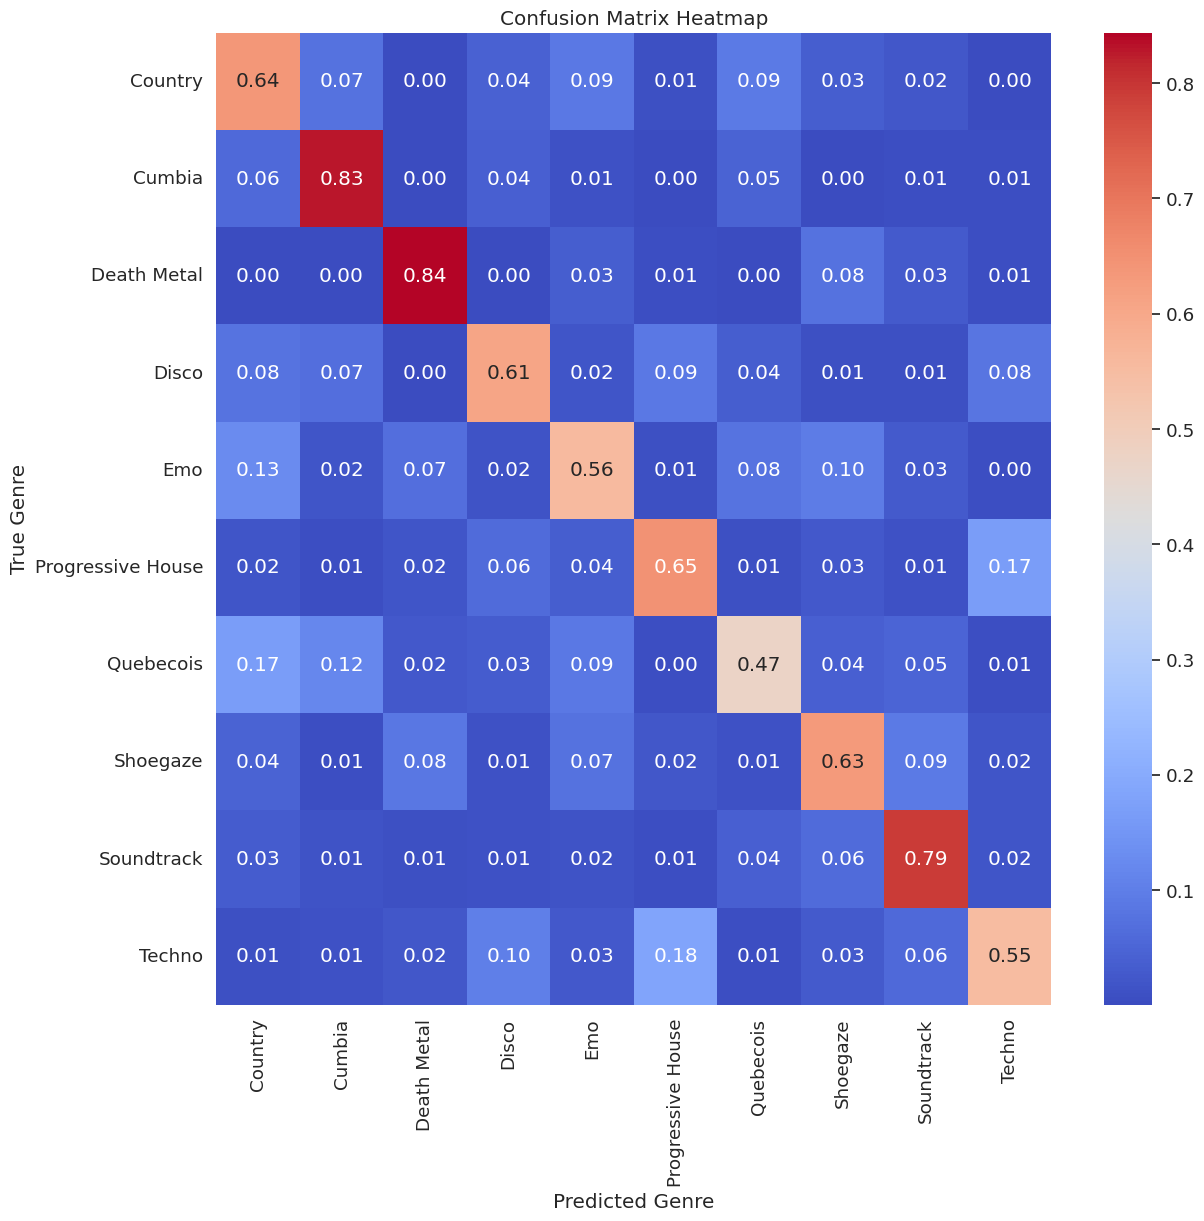

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_real_names, forest_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

The same interference between similar genres continues to show up for Techno, Progressive House, and Disco. Our worst genre, Quebecois, is mistakenly identified as many other genres, although the confusion is worst for Country, Cumbia, and Emo in that order.

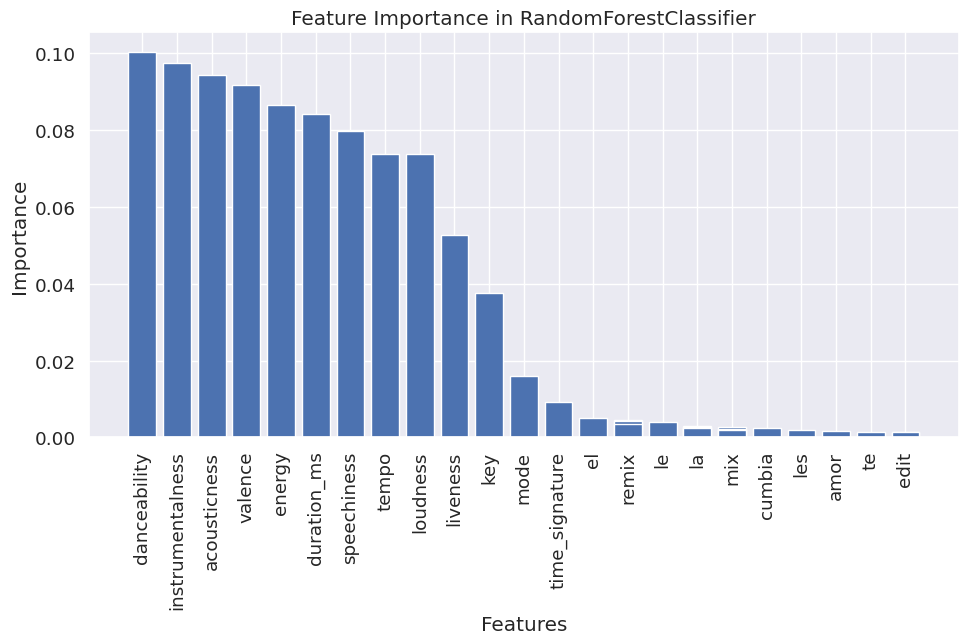

In [ ]:
# Call the feature_importance_ field on the best performing classifier.
importances = forest_grid.best_estimator_ \
                          .named_steps['classifier'] \
                          .feature_importances_
feature_names = X_train.columns

# Convert to DataFrame.
feature_importances = pd.DataFrame({'feature': feature_names, 
                                    'importance': importances})

# Show top this many top features.
FEATURES_TO_DISPLAY = 30

# Sort the DataFrame by importance in descending order
sorted_feature_importances = feature_importances.sort_values('importance', ascending=False)[:FEATURES_TO_DISPLAY]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_importances['feature'], sorted_feature_importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in RandomForestClassifier')
plt.xticks(rotation=90)
plt.show()


Finally, we'll look at the importance of various features for our model. Importance in random forest is determined by the features that were able to achieve the highest decrease in impurity in the various underlying trees.

Based on this metric, we see that danceability is the most important for identifying genres, with the other audio features calculated by Spotify following closely behind. The more natural audio features (that are musically defined for each song and not calculated by Spotify), are less important by about half.

Finally, random forest didn't find our textual features very useful, which is reflected by their much lower importance score.

### References:
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
* https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/
* https://www.section.io/engineering-education/hyperparmeter-tuning/
* https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=max_depth%3A%20The%20number%20of%20splits,shown%20to%20each%20decision%20tree.

## Light Gradient Boosting Machine (LightGMB)

Finally, we'll try to expand on the success of our random forest model with another decision tree-based model.

LightGBM, which stands for 'Light Gradient Boosting Machine,' is an ensemble model similar to random forest. It is a gradient boosting framework that uses tree-based learning algorithms. The main advantage of LightGBM over other tree-based models like random forest is its efficiency and scalability. It is particularly suitable for large datasets or when computational resources are limited.

Compared to random forest, which trains trees in parallel, LightGBM adds each tree sequentially, attempting to correct for the errors in the previous trees in the new trees. This results in a better model performance. Another significant difference between the two models is the way they grow trees. Random forest grows trees level-wise, while LightGBM grows trees leaf-wise, leading to a more efficient and accurate model.

We have chosen to use RobustScaler in the pipeline because it performed well in random forest and works best in our initial testing on a small subset of data.

We'll set a few key hyperparameters, such as num_leaves, min_data_in_leaf, max_depth, learning_rate, and n_estimators. num_leaves is the number of leaves in one tree, and min_data_in_leaf is the minimum number of data points required to form a leaf node. These hyperparameters help control the complexity of the model. max_depth limits the maximum depth of the tree, while learning_rate and n_estimators are unique to gradient boosting models. The learning rate controls the contribution of each tree, and n_estimators is the number of boosting iterations (trees) to be built.

In [ ]:
start = time.time()

# Create a pipeline with RobustScaler and LGBMClassifier
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', lgb.LGBMClassifier(random_state=seed, 
                                      max_depth=5,
                                      n_estimators=150
                                      ))
])

# Define the parameter search space for GridSearchCV
param_grid = {
    'classifier__num_leaves': [31, 50],
    'classifier__min_data_in_leaf': [20, 40],
    'classifier__learning_rate': [.01, .1]
}

# Initialize the GridSearchCV
lgbm_grid = GridSearchCV(pipe, param_grid, cv=5)
lgbm_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", lgbm_grid.best_params_)
print("Best score found: ", lgbm_grid.best_score_)

# Predict using the best estimator
lgbm_pred = lgbm_grid.predict(X_test)

# Inverse transform the labels to get their real names
lgbm_pred_real_names = genre_encoder.inverse_transform(lgbm_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, lgbm_pred_real_names)
for line in report_str.split('\n'):
    print(line)

stop = time.time()
print('Time to run:', round(stop - start, 2))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

In [ ]:
lgmb_results = pd.DataFrame(lgbm_grid.cv_results_)

# Store for future analysis.
lgmb_results.to_csv('lgbm_results.csv', index=False, encoding='utf-8')

# Display the best-performing combiantions.
lgmb_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__min_data_in_leaf,param_classifier__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,11.145160,0.178618,1.852922,0.026092,0.1,40,31,"{'classifier__learning_rate': 0.1, 'classifier...",0.667490,0.673572,0.666097,0.671988,0.677942,0.671418,0.004273,1
7,11.171247,0.436306,1.844003,0.016443,0.1,40,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.668440,0.672621,0.664576,0.672241,0.678323,0.671240,0.004589,2
5,11.740032,0.673243,1.861009,0.033593,0.1,20,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.665526,0.670974,0.664830,0.672621,0.679526,0.670696,0.005346,3
4,11.044289,0.163864,1.839179,0.016378,0.1,20,31,"{'classifier__learning_rate': 0.1, 'classifier...",0.668250,0.671734,0.662549,0.671418,0.679019,0.670594,0.005351,4
0,13.819861,0.513059,1.777089,0.017642,0.01,20,31,"{'classifier__learning_rate': 0.01, 'classifie...",0.614025,0.622197,0.615229,0.622387,0.632522,0.621272,0.006599,5


Overall the larger learning rate parameter was the best option in the majority of cases. A min data in leaf of 40 performed best, whereas the conclusion for the number of leaves was mixed.

Based on the best hyperparameters we were able to identify we'll train a final XGBoost model.

In [ ]:
# Create a pipeline 
final_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', lgb.LGBMClassifier(random_state=seed, 
                                      max_depth=5,
                                      learning_rate=0.1,
                                      n_estimators=150,
                                      min_data_in_leaf=40,
                                      num_leaves=31))])

final_pipe.fit(X_train_smote, y_train_smote)

final_pred = final_pipe.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
final_pred_real_names = genre_encoder.inverse_transform(final_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, final_pred_real_names)
for line in report_str.split('\n'):
    print(line)
    

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
                   precision    recall  f1-score   support

          Country       0.56      0.68      0.61      1854
           Cumbia       0.78      0.82      0.80      1928
      Death Metal       0.82      0.84      0.83      1958
            Disco       0.63      0.64      0.63      1742
              Emo       0.59      0.57      0.58      1750
Progressive House       0.68      0.67      0.68      1767
        Quebecois       0.65      0.49      0.56      1849
         Shoegaze       0.63      0.65      0.64      1768
       Soundtrack       0.73      0.78      0.75      1738
           Techno       0.66      0.58      0.62      1874

         accuracy                           0.67     18228
        macro avg       0.67      0.67      0.67     18228
     weighted avg       0.67      0.67      0.67     18228



Our accuracy is slightly higher, but essentially within a rounding error of the accuracy achieved by random forest. Nevertheless, this model was significantly faster to tune and train, which will become valuable if more data is collected in the future, making training and tuning more difficult.

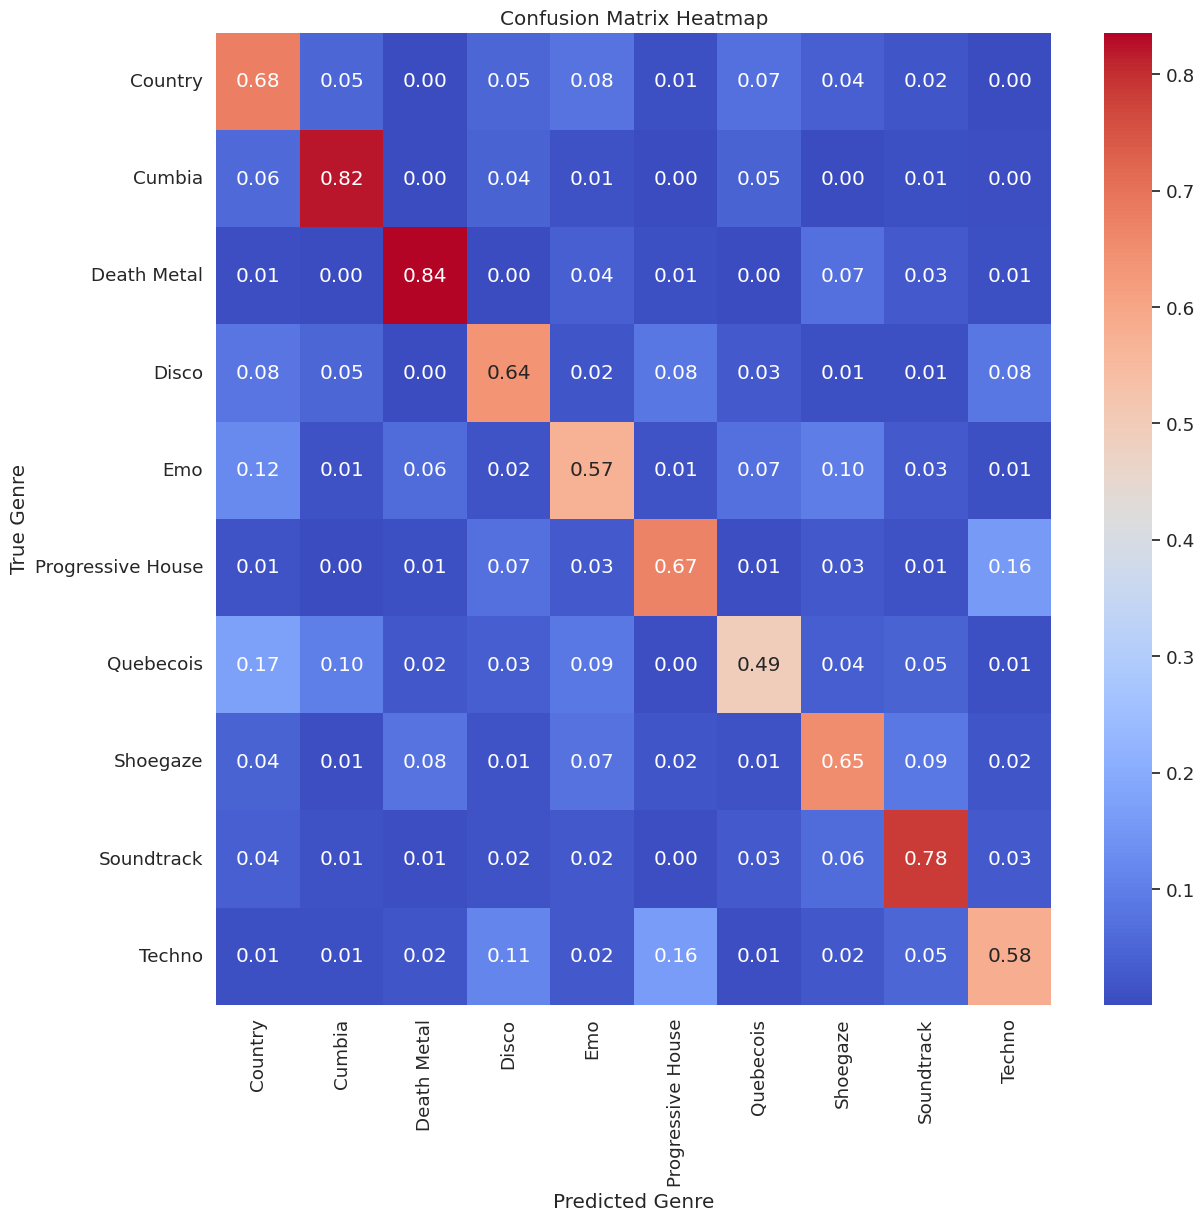

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_real_names, final_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

The same similar-genre interference patterns continue to show up for LightGBM compared to random forest.

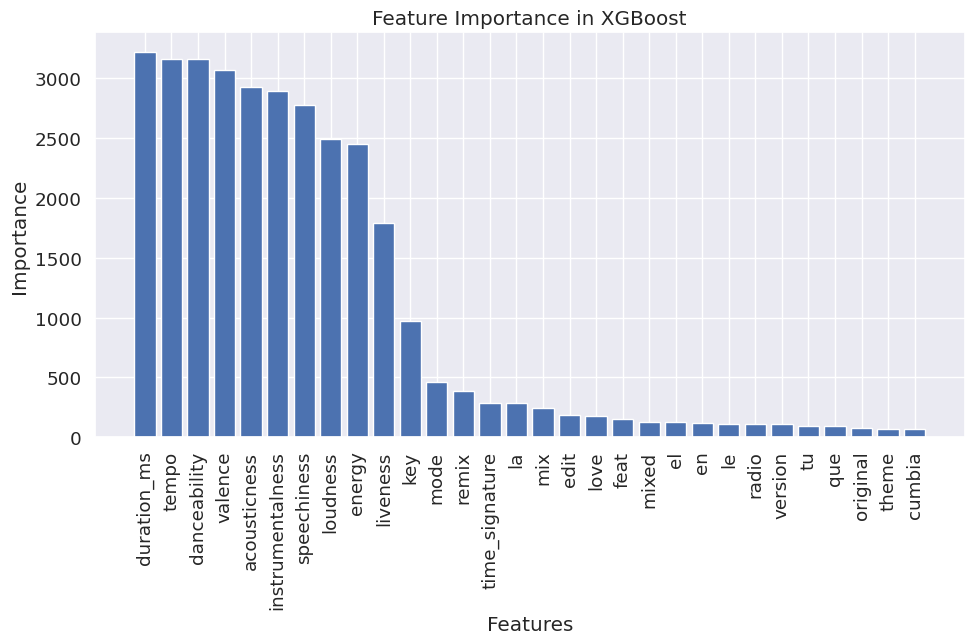

In [ ]:
importances = lgbm_grid.best_estimator_ \
                      .named_steps['classifier'] \
                      .feature_importances_
feature_names = X_train.columns

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Display this many top features.
FEATURES_TO_DISPLAY = 30

# Sort the DataFrame by importance in descending order
sorted_feature_importances = feature_importances.sort_values('importance', ascending=False)[:FEATURES_TO_DISPLAY]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_importances['feature'], 
        sorted_feature_importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.xticks(rotation=90)
plt.show()

Our important features in LightGBM are somewhat different than in random forest. The textual features continue to be less important; however, the natural features like duration and tempo emerge as being more important that the features engineered by Spotify like danceability. Future modeling should investigate this discrepancy to see if similar models can be further improved.

References:
* https://neptune.ai/blog/xgboost-vs-lightgbm#:~:text=In%20contrast%20to%20the%20level,higher%20accuracy%20while%20being%20faster.
* https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d
* https://lightgbm.readthedocs.io/en/latest/Parameters.html
* https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
* https://neptune.ai/blog/lightgbm-parameters-guide